# Processing and integrating 5k PBMCs CITE-seq data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/martinrohbeck/PDC2022Stegle/blob/master/data-integration/preprocess_citeseq.ipynb)

This notebooks provides an example for CITE-seq data processing in Python.

CITE-seq is a method for cellular indexing of transcriptomes and epitopes by sequencing. CITE-seq data is single-cell data comprising transcriptome-wide measurements for each cell (gene expression) as well as surface protein level information, typically for a few dozens of proteins. The method is described in [Stoeckius et al., 2017](https://www.nature.com/articles/nmeth.4380) and also [on the cite-seq.com website](https://cite-seq.com/).

The data used in this notebook is on peripheral blood mononuclear cells (PBMCs) and [has been provided by 10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).

## Download data

[The data is available here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).
Both filtered and raw matrices are required for this notebook.

In [54]:
!wget "https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5"
!wget "https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_raw_feature_bc_matrix.h5"

--2024-11-03 11:06:02--  https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17129253 (16M) [binary/octet-stream]
Saving to: ‘5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5.1’

5k_pbmc_protein_v3_ 100%[===================>]  16,33M  28,2MB/s    in 0,6s    

2024-11-03 11:06:03 (28,2 MB/s) - ‘5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5.1’ saved [17129253/17129253]

--2024-11-03 11:06:03--  https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443

## Load libraries and data

In [55]:
# Here we make sure all necessary packages are installed
# Note: The ! in the beginning of the command makes it execute in the shell rather than python
# !pip install scanpy
# !pip install muon
# !pip3 install leidenalg

Import libraries:

In [56]:
import numpy as np
import pandas as pd
import scanpy as sc

In [57]:
import muon as mu
from muon import prot as pt
mu.set_options(display_style="html", display_html_expand=0b000) # This will make displaying mudata objects interactive

First, we will load filtered matrices that contain counts for cell but not empty droplets. These cells will be used for the downstream analysis.

In [58]:
mdata = mu.read_10x_h5("5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()
mdata

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/m

rna,bool,numpy.ndarray,
prot,bool,numpy.ndarray,


Next, we will also load count matrices for all the droplets, whether containing cells or empty.

In [59]:
mdata_raw = mu.read_10x_h5("5k_pbmc_protein_v3_raw_feature_bc_matrix.h5")
mdata_raw.var_names_make_unique()

mdata_raw

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/m

rna,bool,numpy.ndarray,
prot,bool,numpy.ndarray,


## Protein

In [60]:
prot = mdata.mod['prot']
prot

AnnData object with n_obs × n_vars = 5247 × 32
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

### DSB normalisation

This normalisation method developed for CITE-seq data uses background droplets defined by low RNA content in order to estimate background protein signal and remove it from the data. [More details and its original implementation are available in the `dsb` GitHub repository](https://github.com/niaid/dsb).

`muon` brings `dsb` normalisation method to Python CITE-seq workflows. 

```py
pt.pp.dsb(mdata, raw=mdata_raw, empty_droplets=droplets)
```

Please note due to the nature of the `dsb` method it behaves in a slightly different way than many other preprocessing and normalisation methods. Its implementation in `muon` offers 2 ways to use the method.

1. Operate on 2 AnnData / MuData objects — filtered and raw. Cell calling from the filtered data is used to define cells in the raw data then.

1. As in the original implementation, operate on raw matrices and then return a copy of the data where only specified cells are kept.

Here, we use the first way of using the method. We would still need to calculate `log10umi` value for each droplet to define which droplets are empty.

In [61]:
mdata_raw['rna'].obs["log10umi"] = np.array(np.log10(mdata_raw['rna'].X.sum(axis=1) + 1)).reshape(-1)

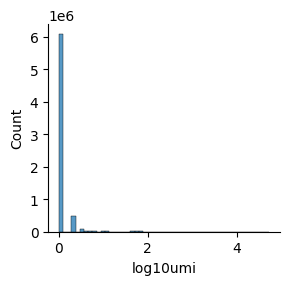

In [62]:
mu.pl.histogram(mdata_raw['rna'], ['log10umi'], bins=50)

For clarity, let's zoom into the part of this data:

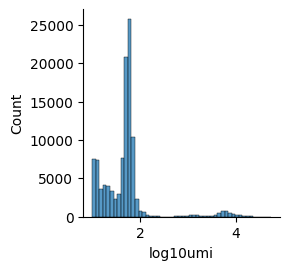

In [63]:
mu.pl.histogram(mdata_raw['rna'][mdata_raw['rna'].obs.log10umi >= 1], ['log10umi'], bins=50)

In this dataset, isotype antibody controls are available that also can be taken into account by the normalisation method:

In [64]:
isotypes = mdata_raw['prot'].var_names[29:32].values
isotypes

array(['IgG1_control_TotalSeqB', 'IgG2a_control_TotalSeqB',
       'IgG2b_control_TotalSeqB'], dtype=object)

Preserve original counts in a layer before the normalisation:

In [65]:
prot.layers['counts'] = prot.X

Normalise counts in `mdata`:

In [66]:
pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.8), isotype_controls=isotypes, random_state=1)

/var/folders/5p/68w6m03x2v3d6q1vdbzf78f40000gn/T/ipykernel_18690/1734432744.py:1: DeprecationWarning: empty_counts_range will be deprecated in the future versions
  pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.8), isotype_controls=isotypes, random_state=1)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/muon/_prot/preproc.py:137: UserWarning: Dropping 49 empty droplets as they are already defined as cells
  warn(


Plot values to visualise the effect of normalisation:

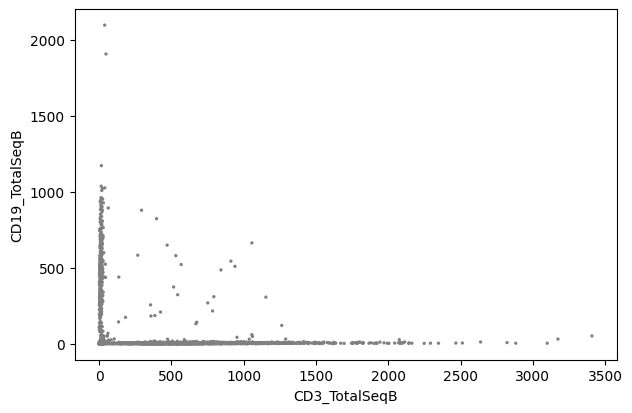

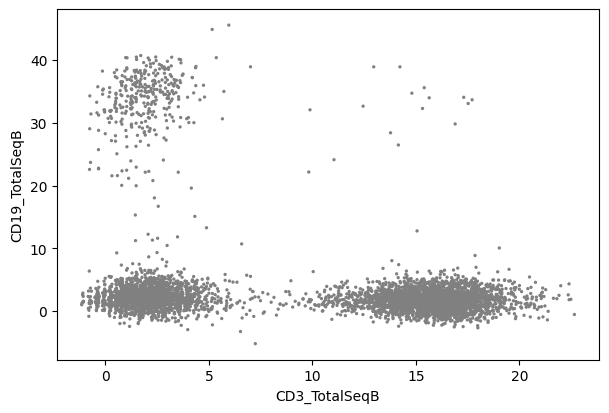

In [67]:
sc.pl.scatter(mdata['prot'], x="CD3_TotalSeqB", y="CD19_TotalSeqB", layers='counts')
sc.pl.scatter(mdata['prot'], x="CD3_TotalSeqB", y="CD19_TotalSeqB")

### Downstream analysis

We can run conventional methods like PCA on the normalised protein counts:

In [68]:
sc.tl.pca(prot)

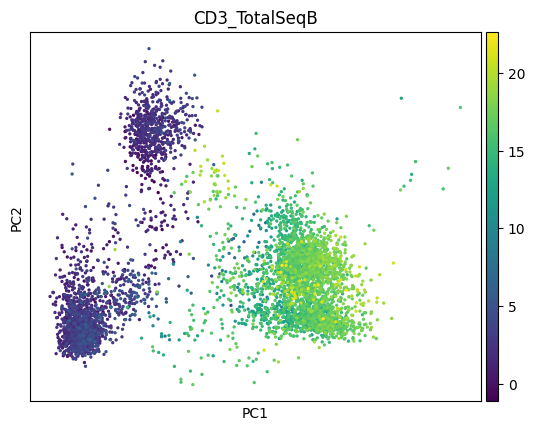

In [69]:
sc.pl.pca(prot, color='CD3_TotalSeqB')

In [70]:
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

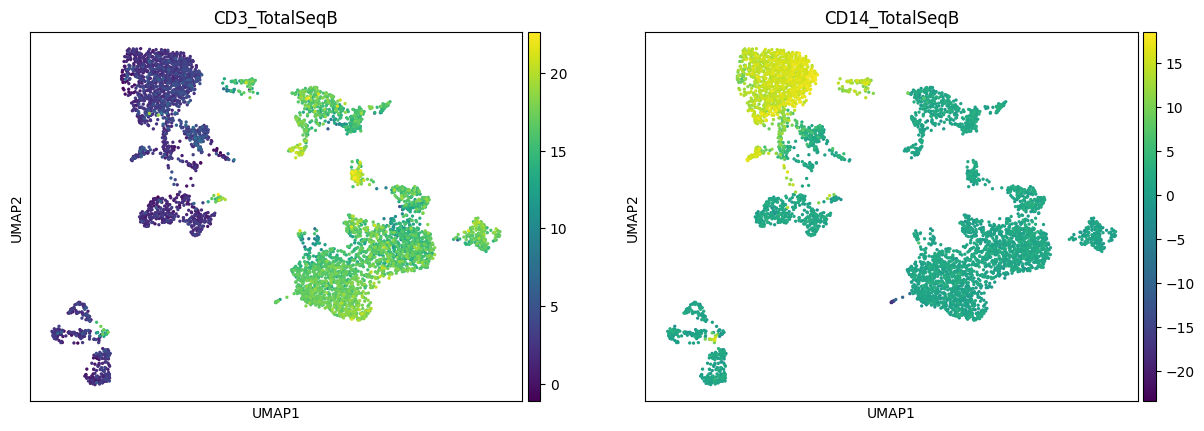

In [71]:
sc.pl.umap(prot, color=['CD3_TotalSeqB', 'CD14_TotalSeqB'])

In [72]:
sc.tl.leiden(prot, resolution=.5)

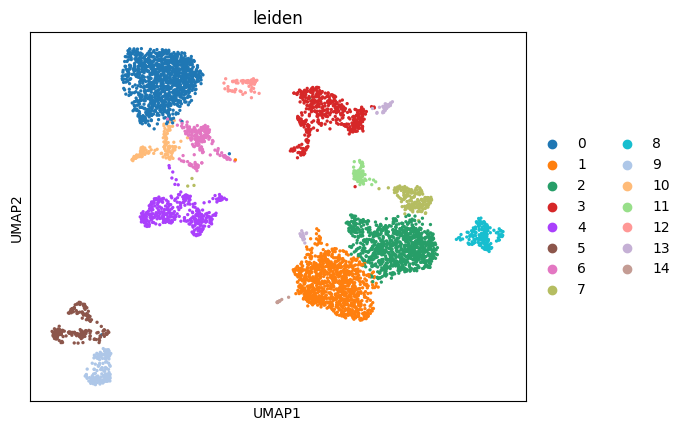

In [73]:
sc.pl.umap(prot, color='leiden')

## RNA

In [74]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 5247 × 33538
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

### QC

Perform some quality control. For now, we will filter out cells that do not pass QC.

In [75]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

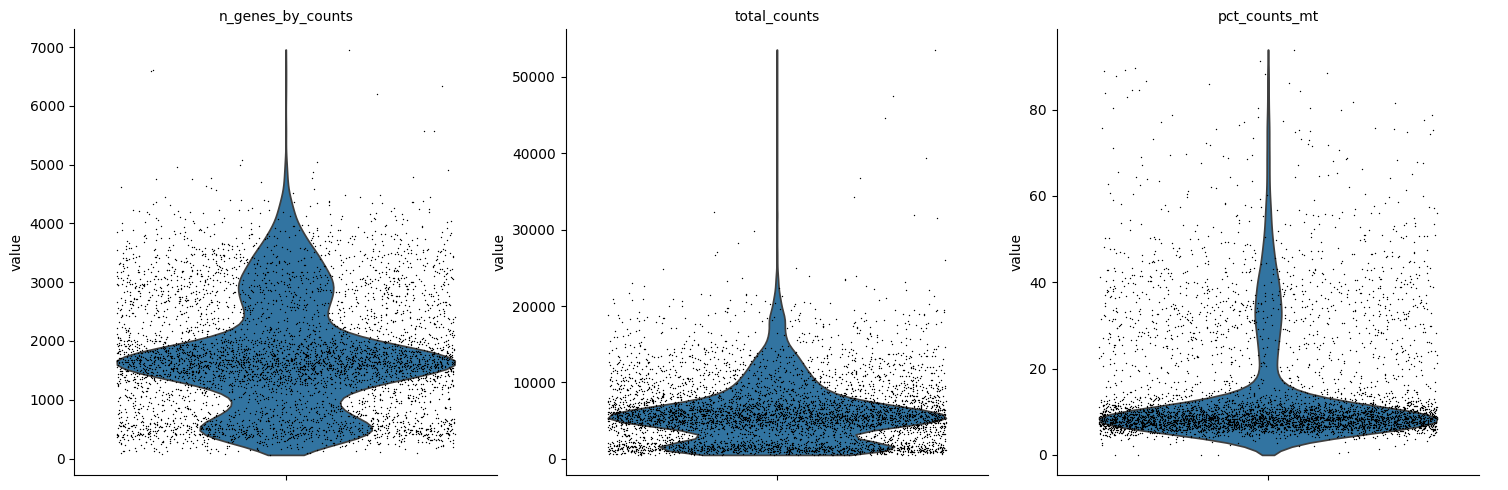

In [76]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Filter genes which expression is not detected:

In [77]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# Same as the following but doesn't copy the object:
#   sc.pp.filter_genes(rna, min_cells=3)

Filter cells:

In [78]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# Same as the following but doesn't copy the object
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]

mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

Let's see how the data looks after filtering:

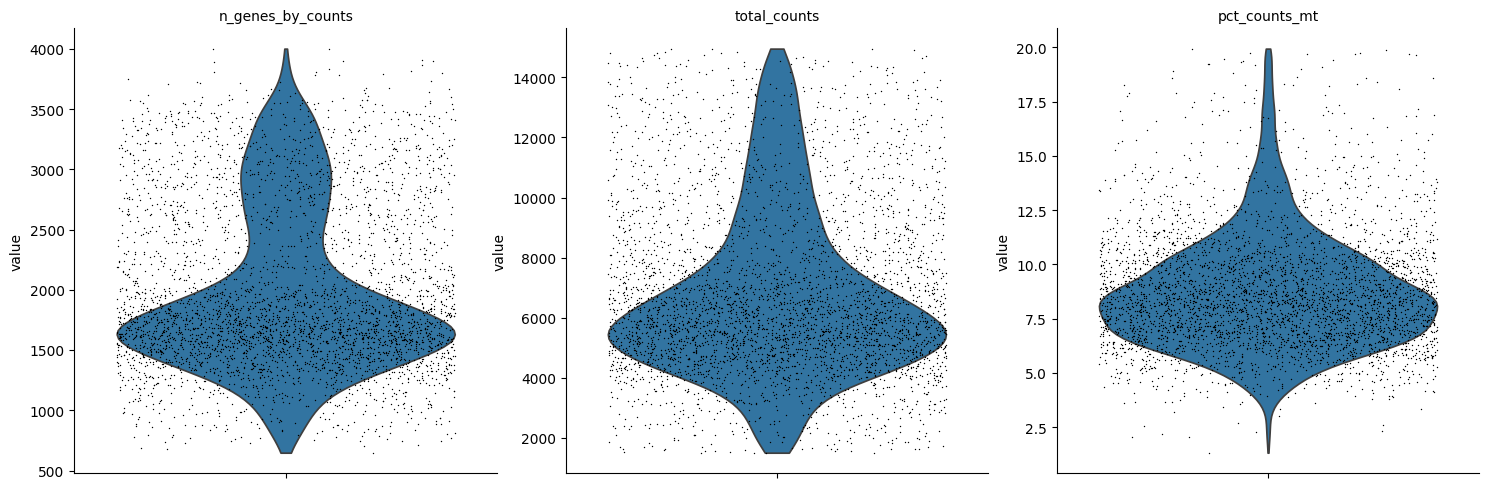

In [79]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

#### Normalisation

We'll normalise the data so that we get log-normalised counts to work with.

In [80]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [81]:
sc.pp.log1p(rna)

#### Feature selection

We will label highly variable genes that we'll use for downstream analysis.

In [82]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

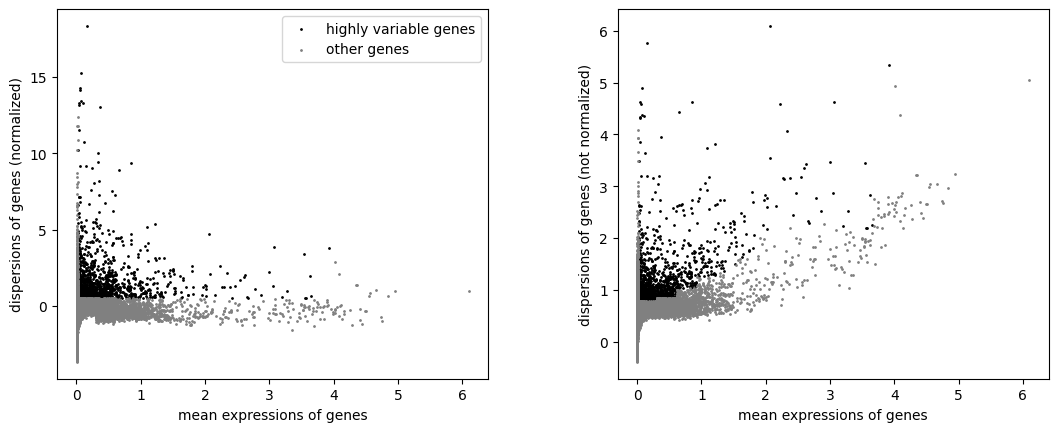

In [83]:
sc.pl.highly_variable_genes(rna)

In [84]:
np.sum(rna.var.highly_variable)

np.int64(1734)

#### Scaling

We'll save log-normalised counts in a `.raw` slot:

In [85]:
rna.raw = rna

... and scale the log-normalised counts to zero mean and unit variance:

In [86]:
sc.pp.scale(rna, max_value=10)

### Analysis

Having filtered low-quality cells, normalised the counts matrix, and performed feature selection, we can already use this data for multimodal integration.

However it is usually a good idea to study individual modalities as well.
Below we run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types.

#### PCA and neighbourhood graph

In [87]:
sc.tl.pca(rna, svd_solver='arpack')

To visualise the result, we will use some markers for (large-scale) cell populations we expect to see such as T cells and NK cells (CD2), B cells (CD79A), and KLF4 (monocytes).

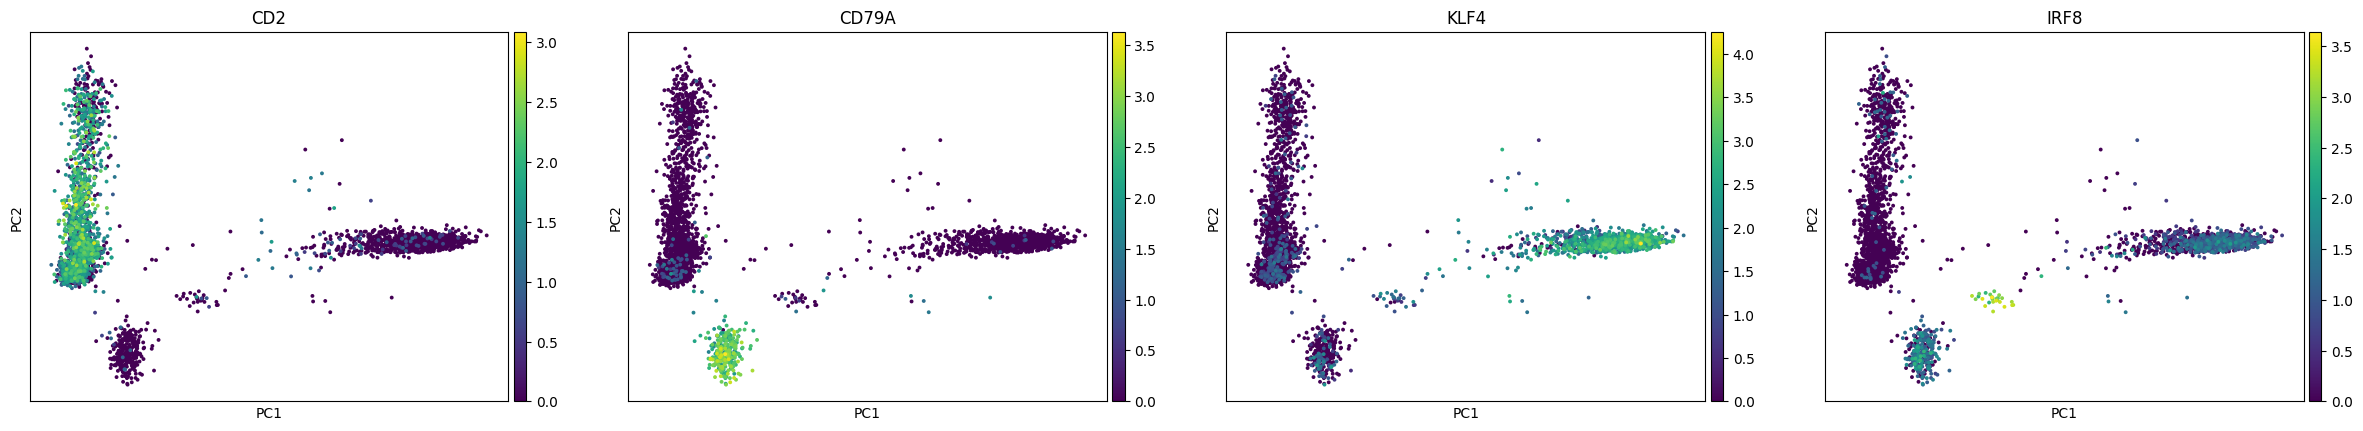

In [88]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

The first principal component (PC1) is separating myeloid (monocytes) and lymphoid (T, B, NK) cells while B cells-related features seem to drive the second one. Also we see plasmocytoid dendritic cells (marked by IRF8) being close to B cells along the PC2.

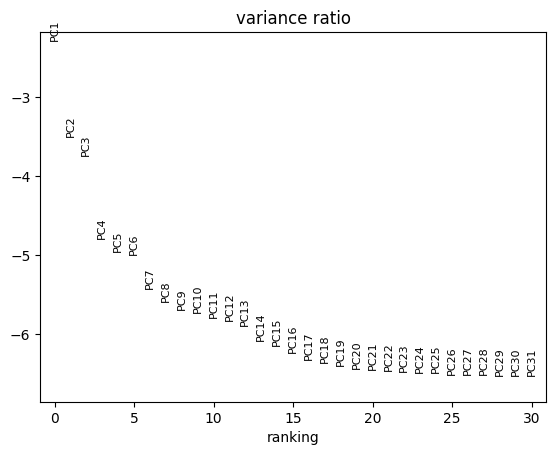

In [89]:
sc.pl.pca_variance_ratio(rna, log=True)

Now we can compute a neighbourhood graph for cells:

In [90]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

#### Non-linear dimensionality reduction and clustering

With the neighbourhood graph computed, we can now perform clustering. We will use `leiden` clustering as an example.

In [91]:
sc.tl.leiden(rna, resolution=.7)

To visualise the results, we'll first generate a 2D latent space with cells that we can colour according to their cluster assignment.

In [92]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

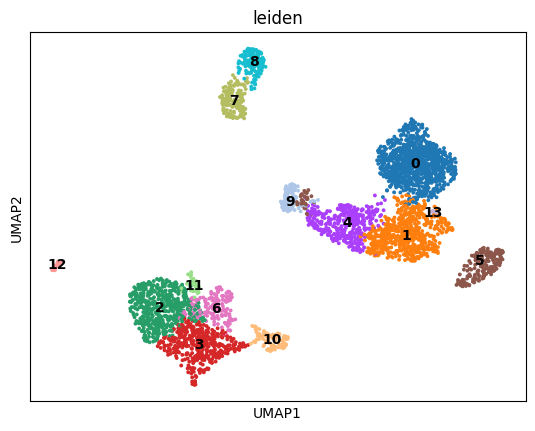

In [93]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

#### Cell type annotation

In [94]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test_overestim_var')

In [95]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p
0,RPS3A,2.692946e-292,IL7R,1.071205e-156,S100A8,1.531958e-286,CST3,9.003905e-146,CCL5,2.560567e-187,GNLY,1.641114e-186,TYMP,1.050705e-56,CD79A,6.409687e-113,IGHM,8.464721e-143,GNLY,1.191776e-68,FCGR3A,7.931314e-73,LYZ,6.609474e-09,ITM2C,1.106096e-36,SLC40A1,0.000013
1,RPL32,1.322684e-278,IL32,6.119916e-127,S100A9,1.733488e-248,CPVL,2.013877e-172,NKG7,4.943438e-141,NKG7,3.789869e-114,LYZ,1.650247e-45,MS4A1,1.513870e-103,CD79A,1.148648e-124,GZMH,1.676262e-77,LST1,3.169948e-44,S100A9,2.003187e-09,CCDC50,3.365557e-34,ANKRD28,0.000257
2,RPL13,3.647643e-257,LTB,1.266784e-109,VCAN,2.878836e-244,LYZ,3.512410e-136,CST7,1.636100e-105,KLRD1,7.549041e-135,FCN1,7.429270e-46,HLA-DQA1,3.751460e-106,CD79B,7.831181e-107,FGFBP2,3.680831e-79,TCF7L2,1.098159e-45,S100A8,3.301095e-09,IL3RA,2.391793e-23,MTURN,0.002283
3,RPL30,1.594375e-260,TRAC,7.290538e-96,S100A12,1.464255e-259,FCN1,3.384967e-132,GZMA,3.492976e-105,PRF1,2.811847e-126,MNDA,8.788522e-48,BANK1,1.331705e-84,IGHD,2.549206e-71,PRF1,4.959480e-71,SMIM25,3.171764e-49,FCN1,6.673663e-08,PLD4,1.246061e-27,AL157895.1,0.007155
4,RPS12,1.259716e-252,CD2,4.366747e-77,MNDA,6.914243e-223,FGL2,9.105865e-137,IL32,1.690156e-88,KLRF1,4.512810e-116,CTSS,2.419919e-43,CD79B,7.403559e-79,MS4A1,2.422108e-88,CST7,8.725091e-64,LYN,1.090890e-46,MNDA,9.093853e-08,IRF8,2.272770e-29,TAGLN2,0.002435
5,RPL11,3.138209e-256,AQP3,3.329718e-61,LYZ,5.131083e-191,KLF4,1.482907e-140,GZMM,1.187806e-82,CTSW,1.667921e-118,CST3,2.190169e-43,HLA-DQB1,6.762205e-69,HLA-DQA1,1.228016e-87,NKG7,7.473949e-55,MS4A7,6.730318e-51,CD14,5.215039e-08,TCF4,2.379913e-28,EIF2AK1,0.002687
6,RPS6,2.152306e-258,CD3E,2.321568e-61,FCN1,8.611265e-197,PSAP,2.023584e-125,KLRG1,9.937855e-73,GZMB,1.677278e-109,FGL2,3.135566e-48,CD37,1.360554e-57,TCL1A,1.705304e-64,KLRC2,9.711829e-59,CDKN1C,2.347007e-39,VCAN,1.692935e-07,UGCG,2.010943e-26,DNAJB6,0.003647
7,RPL9,1.831234e-252,CD3D,4.441340e-56,CTSS,3.683350e-170,AIF1,7.005672e-124,CD3D,5.724024e-72,GZMA,1.703807e-105,S100A9,2.230054e-44,RALGPS2,1.241454e-54,CD37,8.820430e-66,GZMB,5.171952e-69,FCER1G,4.274694e-38,CTSS,4.879190e-07,IRF7,3.697919e-27,PBX1,0.012683
8,TPT1,5.334219e-253,SPOCK2,6.733017e-54,CD14,1.980173e-206,HLA-DRA,2.035732e-122,B2M,4.943399e-68,CLIC3,1.985127e-87,PSAP,1.495800e-42,HLA-DPB1,4.220411e-51,HLA-DPB1,6.584160e-47,CCL5,2.222645e-50,LRRC25,3.008406e-45,TYMP,5.904601e-07,JCHAIN,2.922104e-22,FHL1,0.012350
9,RPL34,1.090842e-245,SYNE2,2.759315e-49,CSF3R,1.208577e-199,CTSS,9.352805e-115,CD8A,4.751880e-51,HOPX,1.368732e-96,CD14,1.407412e-49,HLA-DRA,2.174336e-45,CD74,4.442140e-43,CD247,1.345808e-56,CFD,5.047004e-41,CST3,1.023632e-06,MZB1,4.527079e-20,CDK6,0.010475


In [96]:
new_cluster_names = {
    "0": "CD4+ naïve T", "13": "Treg", "1": "CD4+ memory T",
    "11": "CD8+ naïve T", "3": "CD8+ memory T", 
    "6": "NK", "9": "memory-like NK",
    "7": "mature B", "8": "pre-B",
    "4": "CD14 mono", "2": "intermediate mono", "5": "intermediate mono", "10": "CD16 mono",
    "12": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.replace(new_cluster_names)
rna.obs.celltype = rna.obs.celltype.astype("category")

We will also re-order categories for the next plots:

In [97]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'Treg',
    'CD8+ naïve T', 'CD8+ memory T', 'NK', 'memory-like NK',
    'pre-B', 'mature B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'pDC'])

mdata.update()

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


... and take colours from a palette:

In [98]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

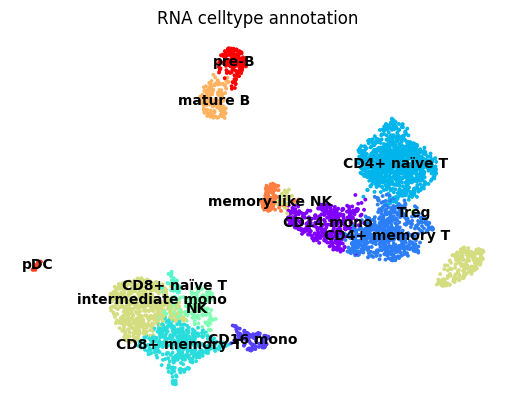

In [99]:
sc.pl.umap(rna, color="celltype", legend_loc="on data", frameon=False,
          title="RNA celltype annotation")

Finally, we'll visualise some marker genes across cell types.

In [100]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'FOXP3', 'IL2RA',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7', 'KLRC2',
                'CD79A', 'MS4A1', 'TCL1A', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b 
                'CD14', 'FCGR3A', 'MS4A7', 
                'CST3', 'IRF8', 'TCF4']

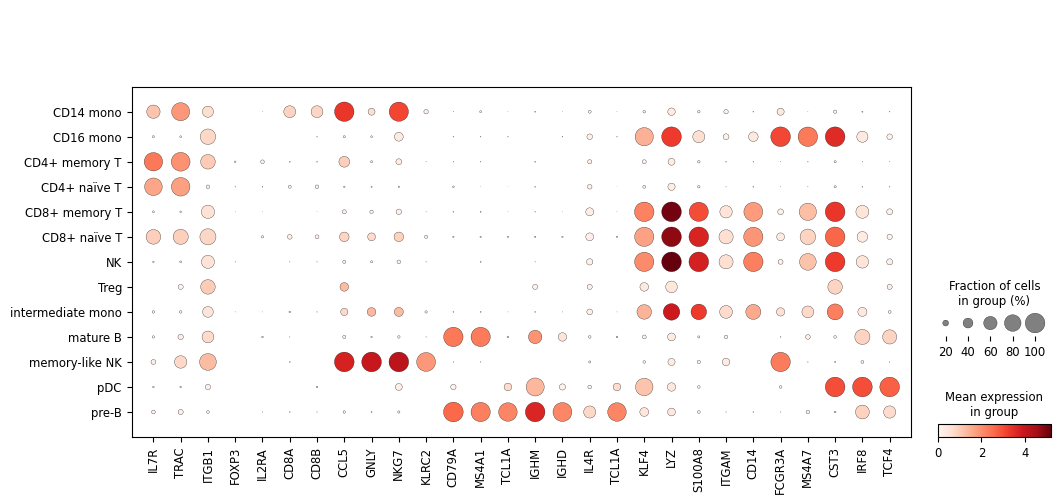

In [101]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

## Update mudata container and sanity check

In [102]:
mu.pp.intersect_obs(mdata) # Only keep cells that are observed in both modalities

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [103]:
mdata.update() # Updates the metadata with the individual modalities

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [104]:
mdata

MuData object with n_obs × n_vars = 3891 × 17838
  var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
  2 modalities
    rna:	3891 x 17806
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'celltype_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    prot:	3891 x 32
      obs:	'leiden'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
      uns:	'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

## Saving multimodal data on disk

We will now write `mdata` object to an `.h5mu` file.

In [105]:
mdata.write("pbmc5k_citeseq.h5mu")

/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/martin/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


If you run the code on Google Colab, you can download the file to your drive by running the following code.
It will allow you to load the file in a different notebook at a later time.